# Construction of Route Graphs

In [55]:
import json
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import isodate
import cvxpy as cp
from functools import reduce
from scipy.sparse import vstack, coo_matrix, csc_matrix

### Load Json

In [69]:
scenario = "problem_instances/sample_scenario.json"  # adjust path to the sample instance if it is not located there
with open(scenario) as fp:
    scenario = json.load(fp)

### Process section requirements

In [70]:
service_intentions = {}
for si in scenario['service_intentions']:
    requirements = {}
    for i,req in enumerate(si['section_requirements']):
        requirements[req['section_marker']] = {key:value for key,value in req.items()}
        if i == 0:
            requirements[req['section_marker']]['start_end'] = 'start'
        elif i == len(si['section_requirements']) - 1:
            requirements[req['section_marker']]['start_end'] = 'end'
        else: 
            requirements[req['section_marker']]['start_end'] = None
    service_intentions[si['id']] = requirements

#get resources
resources = {}
for resource in scenario['resources']:
    idx = resource['id']
    if idx in resources:
        print('something is wrong')
    resources[idx] = resource['release_time']

### Printing of nodes

In [71]:
def from_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_entry" in route_section.keys() and \
            route_section["route_alternative_marker_at_entry"] is not None and \
            len(route_section["route_alternative_marker_at_entry"]) > 0:
                return "(" + str(route_section["route_alternative_marker_at_entry"][0]) + ")"
    else:
        if index_in_path == 0:  # can only get here if this node is a very beginning of a route
            return "(" + str(route_section["sequence_number"]) + "_beginning)"
        else:
            return "(" + (str(route_path["route_sections"][index_in_path - 1]["sequence_number"]) + "->" +
                          str(route_section["sequence_number"])) + ")"
def to_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_exit" in route_section.keys() and \
            route_section["route_alternative_marker_at_exit"] is not None and \
            len(route_section["route_alternative_marker_at_exit"]) > 0:

                return "(" + str(route_section["route_alternative_marker_at_exit"][0]) + ")"
    else:
        if index_in_path == (len(route_path["route_sections"]) - 1): # meaning this node is a very end of a route
            return "(" + str(route_section["sequence_number"]) + "_end" + ")"
        else:
            return "(" + (str(route_section["sequence_number"]) + "->" +
                          str(route_path["route_sections"][index_in_path + 1]["sequence_number"])) + ")"

### Construct graph for every SI, and appropriate edge constraints

In [72]:
route_section_keys = ['penalty', 'minimum_running_time']
section_requirement_keys = ['start_end','min_stopping_time', 'entry_earliest', 'entry_latest',
                           'exit_earliest', 'exit_latest', 'entry_delay_weight',
                           'exit_delay_weight']

In [73]:
start_time = time.time()

# now build the graph. Nodes are called "previous_FAB -> next_FAB" within lineare abschnittsfolgen and "AK" if
# there is an Abschnittskennzeichen 'AK' on it
route_graphs = dict()
for route in scenario["routes"]:# iterates over si?
    
    print(f"\nConstructing route graph for route {route['id']}")
    # set global graph settings
    G = nx.DiGraph(route_id = route["id"], name="Route-Graph for route "+str(route["id"]))

    # add edges with data contained in the preprocessed graph
    for path in route["route_paths"]:#iterate over admissible routes
        print('new route')
        for (i, route_section) in enumerate(path["route_sections"]):
            sn = route_section['sequence_number']
            print("Adding Edge from {} to {} with sequence number {}".format(from_node_id(path, route_section, i), to_node_id(path, route_section, i), sn))
            edge_data = {}
            for key in route_section_keys:
                if key in route_section:
                    edge_data[key] = route_section[key]
                else:
                    edge_data[key] = None
                
            if 'resource_occupations' in route_section:
                resource_occupations = {}
                for resource in route_section['resource_occupations']:
                    idx = resource['resource']
                    R = resources[idx]
                    resource_occupations[idx] = R
                    #maximum? code below
                    R=[isodate.parse_duration(value).seconds for key,value in resource_occupations.items()]
            edge_data['resource_occupations'] = resource_occupations
            edge_data['R'] = max(R)
            
            #get section marker
            section_marker = None
            if 'section_marker' in route_section:
                try:
                    section_marker = route_section['section_marker'][0]
                except:
                    pass
            edge_data['section_marker'] = section_marker
            
            
            
            if section_marker in service_intentions[route['id']]:
                for key in section_requirement_keys:
                    if key in service_intentions[route['id']][section_marker]:
                            edge_data[key] = service_intentions[route['id']][section_marker][key]
        
            edge_data['sequence_number'] = sn
            
            print(edge_data)
            G.add_edge(from_node_id(path, route_section, i),
                       to_node_id(path, route_section, i),
                       edge_data = edge_data)

    route_graphs[route["id"]] = G

print("Finished building fahrweg-graphen in {} seconds".format(str(time.time() - start_time)))


Constructing route graph for route 111
new route
Adding Edge from (1_beginning) to (M1) with sequence number 1
{'penalty': None, 'minimum_running_time': 'PT53S', 'resource_occupations': {'A1': 'PT30S', 'AB': 'PT30S'}, 'R': 30, 'section_marker': 'A', 'start_end': 'start', 'entry_earliest': '08:20:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 1}
Adding Edge from (M1) to (4->5) with sequence number 4
{'penalty': None, 'minimum_running_time': 'PT32S', 'resource_occupations': {'AB': 'PT30S'}, 'R': 30, 'section_marker': None, 'sequence_number': 4}
Adding Edge from (4->5) to (M2) with sequence number 5
{'penalty': None, 'minimum_running_time': 'PT32S', 'resource_occupations': {'B': 'PT30S'}, 'R': 30, 'section_marker': 'B', 'start_end': None, 'min_stopping_time': 'PT3M', 'exit_earliest': '08:30:00', 'entry_delay_weight': 1, 'exit_delay_weight': 1, 'sequence_number': 5}
Adding Edge from (M2) to (M3) with sequence number 6
{'penalty': None, 'minimum_running_time': 'PT

In [74]:
Lats = {}
for si in route_graphs:
    Latins = {}
    Latouts = {}
    for e in route_graphs[si].edges(data=True):
        if 'entry_latest' in e[2]['edge_data']:
            Latins[f'{e[0]},{e[1]}'] = e[2]['edge_data']['entry_latest']
        if 'exit_latest' in e[2]['edge_data']:
            Latouts[f'{e[0]},{e[1]}'] = e[2]['edge_data']['exit_latest']
        Lats[si] = {'LatIn': None, 'LatOut':None}
        Lats[si]['LatIn'] = Latins
        Lats[si]['LatOut'] = Latouts

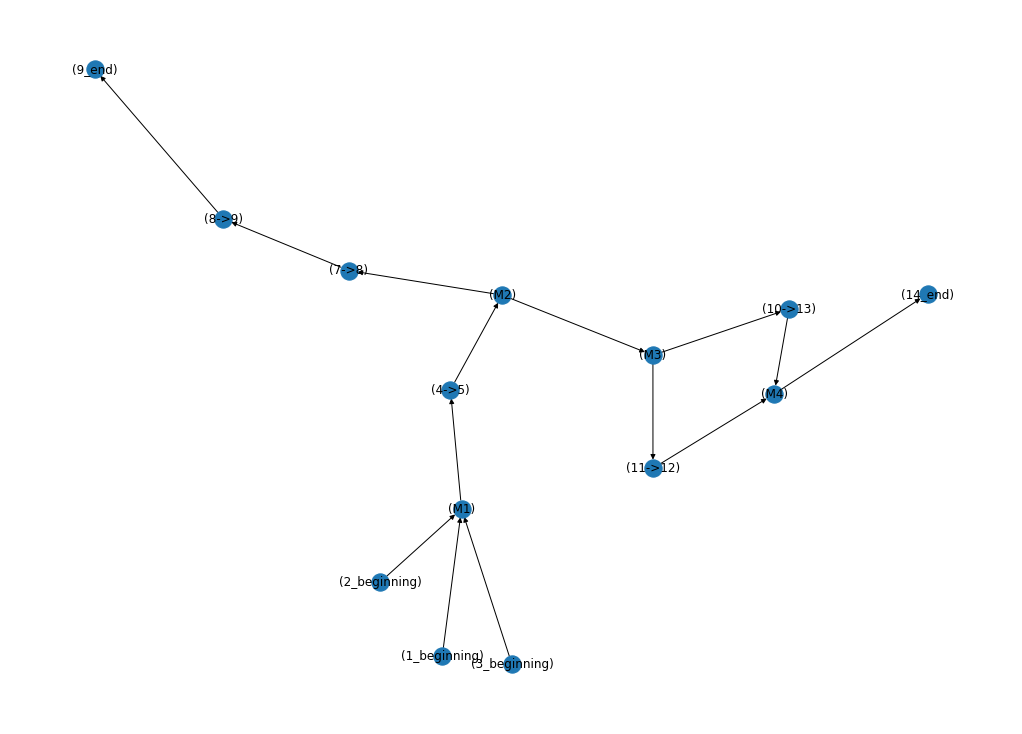

In [80]:
G = None
for route in route_graphs:
    if G:
        G = nx.compose(G, route_graphs[route])
    else:
        G =  route_graphs[route]
pos = nx.spring_layout(G, scale=100)#, k=3/np.sqrt(G.order()))
nx.draw(G, pos=pos, with_labels=True)#, k=13.8, node_color='lightgreen', node_size=800)

In [68]:
b = len(G.edges)/len(G.nodes)
sumoutsquared = 0
for node in G.nodes:
    curr = 0
    for j in G.successors(node):
        curr+=1
    outsqared = curr**2
    sumoutsquared += outsqared
print(sumoutsquared/len(G.nodes) - b**2)

0.2857142857142858


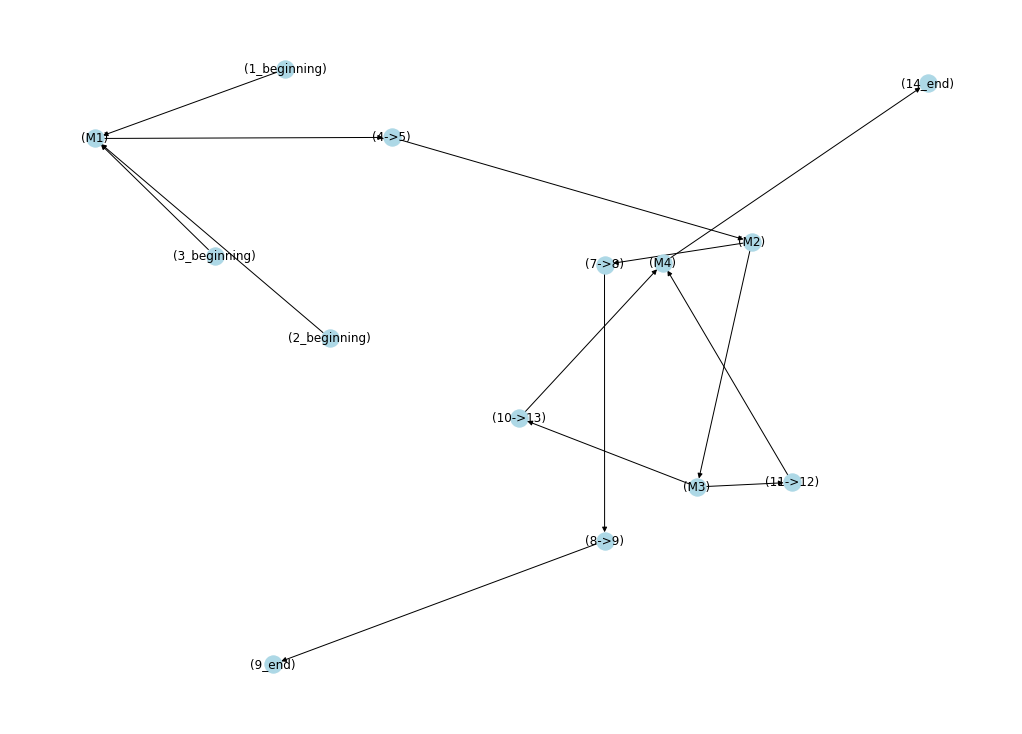

In [77]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
d = dict(G.degree)
nx.draw(G, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d)

### Draw Graphs

In [9]:
edge_labels = {}
for node1, node2, data in route_graph.edges(data=True):

    edge_labels[(node1, node2)] = data['edge_data']['sequence_number']

# draw directly from networkx
pos = nx.spring_layout(route_graph)
nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
plt.show()

KeyError: 856

### Find all admissible routes

In [31]:
paths = {}
for si in service_intentions:
    startnodes=[]
    endnodes = []
    G = route_graphs[si]
    for edge in G.edges(data=True):
        if 'start_end' in edge[2]['edge_data']:
            if edge[2]['edge_data']['start_end'] == 'start':
                startnodes.append(edge[0])
            if edge[2]['edge_data']['start_end'] == 'end':
                endnodes.append(edge[1])
    paths_si = []
    for s in startnodes:
        for e in endnodes:
            for path in nx.all_simple_paths(G, source=s, target=e):
                paths_si.append([(path[i], path[i+1]) for i in range(len(path)-1)])
    paths[si] = paths_si

In [32]:
si_list = []
t_index_by_edge = {}
delta_index_by_edge = {}
edges_by_path = {}
get_index_by_delta = {}
j=0
k=0
for si in paths:
    pathlist = []
    ttemp = {}
    dtemp = {}
    for i,path in enumerate(paths[si]):
        srlist = []
        etemp = {}
        for sr in path:
            srlist.append((si,i,sr))
            if sr in ttemp:
                ttemp[sr].append(j)
            else:
                ttemp[sr] = [j]
            
            
            if sr in dtemp:
                dtemp[sr].append(k)
            else:
                dtemp[sr] = [k]
            
            etemp[sr] = j
            if k in get_index_by_delta:
                get_index_by_delta[k].append(j)
            else:
                get_index_by_delta[k] = [j]
            j+=1
        edges_by_path[k] = etemp
            
        k+=1
        pathlist.append(srlist)
    t_index_by_edge[si] = ttemp
    delta_index_by_edge[si] = dtemp
    si_list.append(pathlist)

In [33]:
xindex = {}
enum = 0
for si in service_intentions:
    xindexsi = {}
    for i,e in enumerate(route_graphs[si].edges):
        xindexsi[e] = i+enum
    enum+=i+1
    xindex[si] = xindexsi

In [34]:
import itertools
betaindex = []
for (si1, si2) in list(itertools.combinations([key for key in service_intentions],2)):
    intsc = list(set.intersection(set(route_graphs[si1].edges), set(route_graphs[si2].edges)))
    for el in intsc:
        s1 = set(route_graphs[si1].edges[el]['edge_data']['resource_occupations'])
        s2 = set(route_graphs[si2].edges[el]['edge_data']['resource_occupations'])
        if len(set.intersection(s1,s2))>0:
            betaindex.append((si1, si2, el))

In [35]:
len(betaindex)

279

In [36]:
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1

In [37]:
t_len = recursive_len(si_list)
x_len = 0
delta_len = 0
for si in service_intentions:
    x_len += len(route_graphs[si].edges)
    delta_len += len(paths[si])
beta_len = len(betaindex)
total_length = t_len*2 + x_len + delta_len + beta_len
total_length

1761

In [38]:
TL={}
i = 0
for si, si_id in zip(si_list, service_intentions):
    temp = {} 
    temp['t'] = recursive_len(si)
    temp['x'] = len(route_graphs[si_id].edges)
    temp['delta'] = len(paths[si_id])
    slacknum = 0
    for r in si:
        for rs in r:
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                slacknum+=1
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                slacknum+=1
            #if 'entry_earliest' in edge_data:
            #    slacknum+=1
            #if 'exit_earliest' in edge_data:
            #    slacknum+=1
            i+=1
    temp['slack'] = slacknum
    TL[si_id] = temp
slack_len = sum([TL[si]['slack'] for si in service_intentions])
total_length+=slack_len

### Variables

|t_in| = sum of the length of all service intentions, total number of paths per si and route sections per path  
|t_out| same as t_in  

|x| all service intentions and their route sections

|delta| all service intentions and their paths

$v = [t_{in}, t_{out} , x, \delta]$

#### Minimize objective function

$J(x)=\{ \frac{1}{60} \sum_{SI, R, RS} win_{rs}max(0, 
t_{si,r,rs}^{in} - LatIn_{si,rs}) + wout_{rs} max(0, t_{si,r,rs}^{out} - LatOut_{si,rs}) + p_{si,rs}x_{si,rs} \}$  



#### Subject to

time into a section comes before time out: 


(1)  $t_{si,r,rs}^{in} \leq t_{si,r,rs}^{out}$  

time into next section comes after time out from previous section:  
(2)  $t_{si,r,rs}^{out} = t_{si,r,rs+1}^{in}$

if r is the selected path, satisfy minimum running and stopping time:  
(3)  $t_{si,r,rs}^{out} - t_{si,r,rs}^{in} \geq mrt_{si, r, rs} + mst_{si, r, rs} - M(1-\delta_{si,r})$

Earliest in constraint:  
(4)  $t_{si,r,rs}^{in} \geq EarIn_{si,r,rs} - M(1-\delta_{si,r})$  

Earliest out constraint:  
(5)  $t_{si,r,rs}^{out} \geq EarOut_{si,r,rs} - M(1-\delta_{si,r})$

Select only one path to every service:  
(6)  $\sum_{r \in P} \delta_{si,r} = 1$  

All route sections on the chosen track are occupied  
(7)  $x_{si, re} \geq \delta_{si, r}$  

(8) $t_{si_1,r_1,re}^{in} - t_{si_2,r_2,re}^{in} \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$  

(9) $t_{si_2,r_2,re}^{in} - t_{si_1,r_1,re}^{in} + \epsilon \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(10) $t_{si_1,r_1,re}^{out} - t_{si_2,r_2,re}^{in} + R \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(11) $t_{si_2,r_2,re}^{out} - t_{si_1,r_1,re}^{in} + R \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

LatIn = entry_latest  
EarOut = exit_earliest  
EarIn = entry_earliest  
LatOut = exit_latest

In [39]:
from time import strftime
from time import gmtime

def str_to_sec(s):
    s=s.split(':')
    return int(s[0])*60*60+int(s[1])*60+int(s[2])
def sec_to_str(x):
    return strftime("%H:%M:%S", gmtime(x))

## Modelling approach

### Display solution

In [40]:
import seaborn as sns
sns.set_style("ticks")
sns.set_style("whitegrid")

In [41]:
def display_solution(x, fsize = 1, labelsize = 200, text = False):
    x = list(x)
    slack, tin, tout, deltas, xs, betas = [],[],[],[],[],[]
    currlen = 0
    for si_id in service_intentions:
        tin += x[currlen + TL[si_id]['slack']:currlen + TL[si_id]['slack'] + TL[si_id]['t']]
        tout += x[currlen + TL[si_id]['slack'] +  TL[si_id]['t']:currlen + TL[si_id]['slack'] + 2*TL[si_id]['t']]
        deltas +=x[currlen + TL[si_id]['slack'] +  2*TL[si_id]['t']:currlen + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta']]
        currlen += TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] + TL[si_id]['x']

    tin = np.array(tin)
    tout = np.array(tout)
    deltas = np.array(deltas)
    deltas = np.round(deltas)
    #betas = betas.value
    ad_paths = np.where(deltas==1)[0]
    paths_flat = []
    timetable = {}
    penalty = 0
    for si in paths:
        paths_flat += paths[si]
    for (si,ad_path) in zip(service_intentions, ad_paths):
        p = paths_flat[ad_path]
        timetable[si] = {'tin': [], 'tout':[], 'e':[]}
        for idx,e in zip(get_index_by_delta[ad_path],p):
            timetable[si]['tin'].append((tin[idx]))
            timetable[si]['tout'].append((tout[idx]))
            
            estr = e[0]+','+e[1]
            timetable[si]['e'].append(estr)
            print(f'si: {si}, edge: {estr}, tin: {sec_to_str(tin[idx])}, tout: {sec_to_str(tout[idx])}')
            if estr in Lats[si]['LatIn']:
                #print('LatIn', Lats[si]['LatIn'][estr])
                pen = max(0,tin[idx] - str_to_sec(Lats[si]['LatIn'][estr]))
                penalty+=pen
            if estr in Lats[si]['LatOut']:
                #print('LatOut', Lats[si]['LatOut'][estr])
                pen= max(0,tout[idx] - str_to_sec(Lats[si]['LatOut'][estr]))
                penalty+=pen
            #print(route_graphs[si].edges[e])
    import matplotlib.pyplot as plt
    #plt.figure(figsize = (15,11.5))
    fig, ax = plt.subplots(figsize = (int(15*fsize),(11.5*fsize)))
    s=labelsize

    for si in timetable:
        ax.scatter(range(len(timetable[si]['tin'])),timetable[si]['tin'], marker = 'o', label = f'{si} entry', s=s)
        ax.scatter(range(1,len(timetable[si]['tout'])+1),timetable[si]['tout'], marker = 'x', label = f'{si} exit', s=s)
    if text:
        for si in timetable:
            for i, txt in enumerate(timetable[si]['e']):
                ax.annotate(timetable[si]['e'][i], (range(len(timetable[si]['tin']))[i], timetable[si]['tin'][i] + 100))
    plt.xlabel('Section sequence')
    plt.ylabel('Time (s)')
    plt.legend()

### Constraints

In [42]:
Mmrtmst = [1]
MEarOut = [1]
MEarIn = [1]
for si in route_graphs:
    for e in route_graphs[si].edges(data=True):
        edge_data = e[2]['edge_data']
        if ('exit_earliest' in edge_data):
            EarOut = str_to_sec(edge_data['exit_earliest'])
            MEarOut.append(EarOut)
        if ('entry_earliest' in edge_data):
            EarIn = str_to_sec(edge_data['entry_earliest'])
            MEarIn.append(EarIn)
        if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
            mst = 0
            mrt = 0
            if 'min_stopping_time' in edge_data:
                mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
            if 'minimum_running_time' in edge_data:
                mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
            Mmrtmst.append(mrt+mst)

In [43]:
ub_numCons_nor = recursive_len(si_list)*11
ub_numCons_coup =  4*sum([len(delta_index_by_edge[si1][e])*len(delta_index_by_edge[si2][e]) for (si1, si2, e) in betaindex])

c = np.zeros(total_length)
testv = [None]*total_length

indexer = {}

#A = lil_matrix((ub_numCons_nor, total_length))
row = []
col = []
data = []
b = np.zeros(ub_numCons_nor)
cnum = 0
cnums = []
currlen = 0
bool_idx = []
for si, si_id in zip(si_list, service_intentions):
    #print(si_id,cnum)
    tempindexer = {'height_loc': [cnum, None], 'width_loc':[currlen, None]}
    tempsum = 0
    j=0
    coltemp = []
    datatemp = []
    i =0
    s=0
    for r, path in zip(si, paths[si_id]):
        for enum, rs in enumerate(r):
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            #slack
            tin_idx = currlen + i + TL[si_id]['slack'] 
            tout_idx = currlen + i + TL[si_id]['slack'] + TL[si_id]['t']
            delta_idx = currlen + j + TL[si_id]['slack'] + 2*TL[si_id]['t']
            ad_x = 0
            for t in service_intentions:
                if t==si_id:
                    break
                ad_x += TL[t]['x']
            x_idx = currlen + xindex[si_id][rs[2]] + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] -ad_x
            
            
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                b[cnum] = float(edge_data['entry_delay_weight'])*str_to_sec(edge_data['entry_latest'])
                row += [cnum, cnum]
                col += [currlen + s, tin_idx]
                data += [-1, float(edge_data['entry_delay_weight'])]
                cnum +=1
                b[cnum] = 0
                row.append(cnum)
                col.append(currlen + s)
                data.append(-1)
                cnum +=1
                
                c[currlen + s] = 1

                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1
                
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                b[cnum] = float(edge_data['exit_delay_weight'])*str_to_sec(edge_data['exit_latest'])
                row += [cnum, cnum]
                col += [currlen + s, tout_idx]
                data += [-1, float(edge_data['exit_delay_weight'])]
                cnum+=1
                
                b[cnum] = 0
                row.append(cnum)
                col.append(currlen + s)
                data.append(-1)
                cnum += 1
                
                c[currlen + s] = 1
                testv[currlen + s] = f'slack_{s}_{si_id}'
                s+=1

            
            b[cnum] = 0
            row.append(cnum)
            col.append(tin_idx)
            data.append(-1)
            cnum+=1
            testv[tin_idx] = f'tin_{i}_{si_id}'
            
            b[cnum] = 0
            row.append(cnum)
            col.append(tout_idx)
            data.append(-1)
            cnum += 1
            testv[tout_idx] = f'tout_{i}_{si_id}'
            
            #(1)
            row += [cnum, cnum]
            col += [tin_idx, tout_idx]
            data += [1,-1]
            b[cnum] = 0
            cnum += 1
            
            # (2)
            if enum!=len(r)-1:
                b[cnum] = 0
                row+=[cnum, cnum]
                col+=[tin_idx+1, tout_idx]
                data += [1,-1]
                cnum += 1
                
                row+=[cnum, cnum]
                col+=[tin_idx+1, tout_idx]
                data += [-1,1]
                b[cnum] = 0
                cnum+=1

            #(3)
            #M=10000000
            M=max(Mmrtmst)
            if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                mst = 0
                mrt = 0
                if 'min_stopping_time' in edge_data:
                    mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                if 'minimum_running_time' in edge_data:
                    mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds

                b[cnum] = M-mrt-mst
                row += [cnum, cnum, cnum]
                col+=[tin_idx, tout_idx, delta_idx]
                data+=[1,-1,M]
                cnum += 1

            # (4)
            M=max(MEarIn)
            if ('entry_earliest' in edge_data):
                EarIn = str_to_sec(edge_data['entry_earliest'])
                print(cnum)
                b[cnum] = M-EarIn
                row += [cnum, cnum]
                col += [tin_idx, delta_idx]
                data += [-1, M]
                cnum += 1

            #(5)
            M=max(MEarOut)    
            if ('exit_earliest' in edge_data):
                EarOut = str_to_sec(edge_data['exit_earliest'])
                
                row +=[cnum, cnum]
                col += [tout_idx, delta_idx]
                data += [-1, M]
                b[cnum] = M-EarOut
                cnum += 1
            # (7)
            b[cnum] = 0
            row += [cnum, cnum]
            col += [delta_idx, x_idx]
            data+= [1,-1]
            cnum += 1
            
            bool_idx.append(delta_idx)
            bool_idx.append(x_idx)
            testv[x_idx] = f'x_{xindex[si_id][rs[2]] - ad_x}_{si_id}'
            testv[delta_idx] = f'delta_{j}_{si_id}'
            
            i+=1
        # (6)
        coltemp.append(delta_idx)
        datatemp.append(1)
        j+=1
    
    tempb = np.array([1])
    b = np.hstack((b[:cnum],tempb,b[cnum:]))
    row += [cnum]*len(coltemp)
    col+= coltemp
    data+=datatemp
    cnum += 1
    
    row += [cnum]*len(coltemp)
    datatemp = [-1*x for x in datatemp]
    col+=coltemp
    data+=datatemp
    tempb = -1*tempb.copy()
    b = np.hstack((b[:cnum],tempb,b[cnum:]))
    cnum += 1
    if len(cnums)==0:
        cnums.append(cnum)
    else:
        cnums.append(cnum - cnums[-1])
    currlen += TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] + TL[si_id]['x']
    tempindexer['height_loc'][1] = cnum
    tempindexer['width_loc'][1] = currlen
    indexer[si_id] = tempindexer 

#print(cnum)
b = b[:cnum]
A = coo_matrix((data, (row, col)), shape=(cnum, total_length))


#objective
currlen = 0    
for si, si_id in zip(si_list, service_intentions):
    for edge in route_graphs[si_id].edges(data=True):
        ad_x = 0
        for t in service_intentions:
            if t==si_id:
                break
            ad_x += TL[t]['x']
        e = (edge[0],edge[1])
        x_idx = currlen + xindex[si_id][e] + TL[si_id]['slack'] + 2*TL[si_id]['t'] + TL[si_id]['delta'] - ad_x
        p = 0
        if 'penalty' in edge[2]['edge_data']:
            p = edge[2]['edge_data']['penalty']
            if p == None:
                p = 0
            else:
                p = float(p)
            c[x_idx]= p
        i+=1   


#coupling
cnum = 0
#A_coup = csr_matrix((ub_numCons_coup, total_length))
b_coup = np.zeros(ub_numCons_coup)
row, col, data = [], [], []

i = 0
eps = 1
M = 100000
R=30
prevsi1, prevsi2, _ = betaindex[0]
LenSI = total_length - beta_len
tempindexer = {'height': [cnum, None], 'width': [LenSI + i, None]}
for (si1, si2, e) in betaindex:
    if prevsi1 != si1 or prevsi2 != si2:
        tempindexer['height'][1] = cnum
        tempindexer['width'][1] = LenSI + i
        indexer[str(prevsi1)+','+str(prevsi2)] = tempindexer
        tempindexer = {'height': [cnum, None], 'width': [LenSI + i, None]}
        prevsi1 = si1
        prevsi2 = si2
        
    deltaidx1 = delta_index_by_edge[si1][e]
    deltaidx2 = delta_index_by_edge[si2][e]
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    adjuster1 = sum([TL[siprevel]['t'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    adjuster2 = sum([TL[siprevel]['t'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    adjuster1d = sum([TL[siprevel]['delta'] for siprevel in prevsi])
    
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    adjuster2d = sum([TL[siprevel]['delta'] for siprevel in prevsi])
    
    sumtil1 = 0
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si1:
            break
        prevsi.append(siprevel)
    sumtil1 = sum([TL[siprevel]['slack'] + 2*TL[siprevel]['t'] + TL[siprevel]['delta'] + TL[siprevel]['x'] for siprevel in prevsi])

    
    sumtil2 = 0
    prevsi = []
    for siprevel in [si for si in service_intentions]:
        if siprevel==si2:
            break
        prevsi.append(siprevel)
    sumtil2 = sum([TL[siprevel]['slack'] + 2*TL[siprevel]['t'] + TL[siprevel]['delta'] + TL[siprevel]['x'] for siprevel in prevsi])

    for idx1 in deltaidx1:
        for idx2 in deltaidx2:
            tin1_idx = edges_by_path[idx1][e] - adjuster1 + sumtil1 + TL[si1]['slack']
            tin2_idx = edges_by_path[idx2][e] - adjuster2 + sumtil2 + TL[si2]['slack']
            tout1_idx = edges_by_path[idx1][e] - adjuster1 + sumtil1 + TL[si1]['slack'] + TL[si1]['t']
            tout2_idx = edges_by_path[idx2][e] - adjuster2 + sumtil2 + TL[si2]['slack'] + TL[si2]['t']
            delta1_idx = idx1+TL[si1]['slack']+2*TL[si1]['t'] - adjuster1d + sumtil1
            delta2_idx = idx2+TL[si2]['slack']+2*TL[si2]['t'] - adjuster2d + sumtil2
            
            #print(f'tin1 {tin1_idx}, tin2 {tin2_idx}, delta1 {delta1_idx}, delta2 {delta2_idx}, beta {LenSI+i}')
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tin2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [1,-1,M,M,M]
            b_coup[cnum]=3*M
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tin2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,-M]
            b_coup[cnum]=2*M-eps
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin2_idx, tout1_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,M]
            b_coup[cnum]=3*M-R
            cnum += 1
            
            
            row+=[cnum,cnum, cnum, cnum, cnum]
            col+=[tin1_idx, tout2_idx, delta1_idx, delta2_idx,LenSI+i]
            data += [-1,1,M,M,-M]
            b_coup[cnum]=2*M-R
            cnum += 1
    testv[LenSI+i] = f'beta_{i}'       
    bool_idx.append(LenSI+i)
    i+=1

bool_idx =list(set(bool_idx))
#print(cnum)
tempindexer['height'][1] = cnum
tempindexer['width'][1] = LenSI + i
indexer[str(si1) + ',' + str(si2)] = tempindexer
A_coup = coo_matrix((data, (row, col)), shape=(cnum, total_length))
b_coup = b_coup[:cnum].flatten()

6
550
1096
1640
2186
2684
3191
3684


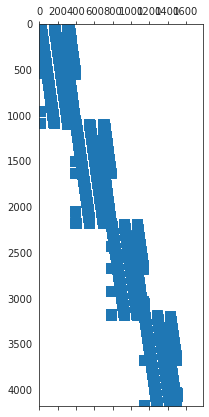

In [45]:
sns.set_style("white")
drawmatrix(A)

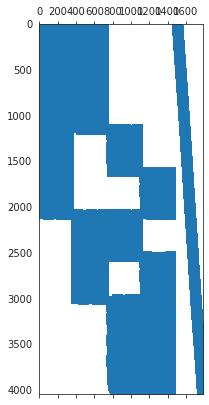

In [46]:
drawmatrix(A_coup)

In [56]:
from scipy.sparse import csc_matrix

In [57]:
At = csc_matrix(vstack((A,A_coup)))
bt = np.hstack((b,b_coup))

import miosqp
m = miosqp.MIOSQP()
P = csc_matrix(np.zeros((total_length,total_length)))
l = np.array([-np.inf]*len(bt))
i_l = np.zeros(len(bool_idx))
i_u = np.ones(len(bool_idx))

miosqp_settings = {
                   # integer feasibility tolerance
                   'eps_int_feas': 1e-03,
                   # maximum number of iterations
                   'max_iter_bb': 1000,
                   # tree exploration rule
                   #   [0] depth first
                   #   [1] two-phase: depth first until first incumbent and then  best bound
                   'tree_explor_rule': 1,
                   # branching rule
                   #   [0] max fractional part
                   'branching_rule': 0,
                   'verbose': False,
                   'print_interval': 1}

osqp_settings = {'eps_abs': 1e-03,
                 'eps_rel': 1e-03,
                 'eps_prim_inf': 1e-04,
                 'verbose': True}
m.setup(P, c, At, l, bt, np.array(bool_idx), i_l, i_u, miosqp_settings, osqp_settings)
results = m.solve()

In [58]:
display_solution(results.x)

NameError: name 'results' is not defined

In [22]:
import seaborn as sns
def drawmatrix(A):
    sns.set_style("white")
    S = 3
    f = A.shape[0]/A.shape[1]
    f2 = 1
    plt.figure(figsize = (S*f2, f*S))
    plt.spy(A)

In [60]:
def len_si(si_id):
    lb = 0
    ub=0
    for si in service_intentions:
        s = 2*TL[si]['t'] + TL[si]['x'] + TL[si]['delta'] + TL[si]['slack']
        ub += s
        if si_id == si:
            return (lb, ub)
        lb+=s
        
def len_cons(si_id):
    lb = 0
    ub=0
    for si,cnum in zip(service_intentions,cnums):
        ub += cnum
        print(lb,ub)
        if si_id == si:
            return (lb, ub)
        lb+=cnum

In [118]:
bool_idx2 = bool_idx[:-beta_len]

In [62]:
lam = np.zeros(len(b_coup))

bool_vars_idx = [(x,) for x in bool_idx]

x = cp.Variable(A.shape[1], boolean = bool_vars_idx)


p = cp.Problem(cp.Minimize(0),
                 [At@x<=bt])
p = p.solve(solver = 'MOSEK', verbose = True)
            #,mosek_params={mosek.iparam.intpnt_solve_form: mosek.solve.primal})

                                     CVXPY                                     
                                    v1.1.14                                    
(CVXPY) Aug 26 06:00:22 AM: Your problem has 27344 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 26 06:00:22 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 26 06:00:22 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 26 06:00:22 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 26 06:00:22 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 26 06:00:22 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

In [63]:
c.T@x.value

132771447.1

In [ ]:
lam = np.zeros(len(b_coup))

bool_vars_idx = [(x,) for x in bool_idx]

x = cp.Variable(A.shape[1], boolean = bool_vars_idx)


p = cp.Problem(cp.Minimize(c.T@x ),
                 [At@x<=bt])
p = p.solve(solver = 'MOSEK', verbose = True)
            #,mosek_params={mosek.iparam.intpnt_solve_form: mosek.solve.primal})

Next one up  

Check relaxed constraints  


Sparse matrix

si: 2408, edge: (1_beginning),(1->5), tin: 07:24:09, tout: 07:25:49
si: 2408, edge: (1->5),(5->10), tin: 07:25:49, tout: 07:26:31
si: 2408, edge: (5->10),(10->12), tin: 07:26:31, tout: 07:33:56
si: 2408, edge: (10->12),(12->15), tin: 07:33:56, tout: 07:34:54
si: 2408, edge: (12->15),(15->20), tin: 07:34:54, tout: 11:13:09
si: 2408, edge: (15->20),(20->25), tin: 11:13:09, tout: 11:14:08
si: 2408, edge: (20->25),(25->30), tin: 11:14:08, tout: 11:15:12
si: 2408, edge: (25->30),(30->35), tin: 11:15:12, tout: 11:15:54
si: 2408, edge: (30->35),(35->40), tin: 11:15:54, tout: 11:16:17
si: 2408, edge: (35->40),(40->45), tin: 11:16:17, tout: 11:16:40
si: 2408, edge: (40->45),(45->50), tin: 11:16:40, tout: 11:16:49
si: 2408, edge: (45->50),(50->55), tin: 11:16:49, tout: 11:16:57
si: 2408, edge: (50->55),(55->60), tin: 11:16:57, tout: 11:18:30
si: 2408, edge: (55->60),(60->65), tin: 11:18:30, tout: 14:55:52
si: 2408, edge: (60->65),(65->70), tin: 14:55:52, tout: 14:56:19
si: 2408, edge: (65->70),(

si: 18823, edge: (295->300),(300->305), tin: 17:22:03, tout: 17:26:08
si: 18823, edge: (300->305),(305_end), tin: 17:26:08, tout: 17:30:13
si: 18825, edge: (1_beginning),(1->5), tin: 10:29:10, tout: 10:30:04
si: 18825, edge: (1->5),(5->10), tin: 10:30:04, tout: 10:30:36
si: 18825, edge: (5->10),(10->15), tin: 10:30:36, tout: 10:30:44
si: 18825, edge: (10->15),(15->20), tin: 10:30:44, tout: 10:30:58
si: 18825, edge: (15->20),(20->25), tin: 10:30:58, tout: 10:31:18
si: 18825, edge: (20->25),(25->30), tin: 10:31:18, tout: 10:32:53
si: 18825, edge: (25->30),(30->35), tin: 10:32:53, tout: 07:28:15
si: 18825, edge: (30->35),(35->37), tin: 07:28:15, tout: 07:28:29
si: 18825, edge: (35->37),(37->40), tin: 07:28:29, tout: 07:29:03
si: 18825, edge: (37->40),(40->45), tin: 07:29:03, tout: 07:29:47
si: 18825, edge: (40->45),(45->50), tin: 07:29:47, tout: 07:30:07
si: 18825, edge: (45->50),(50->52), tin: 07:30:07, tout: 07:30:49
si: 18825, edge: (50->52),(52->55), tin: 07:30:49, tout: 07:31:23
si: 

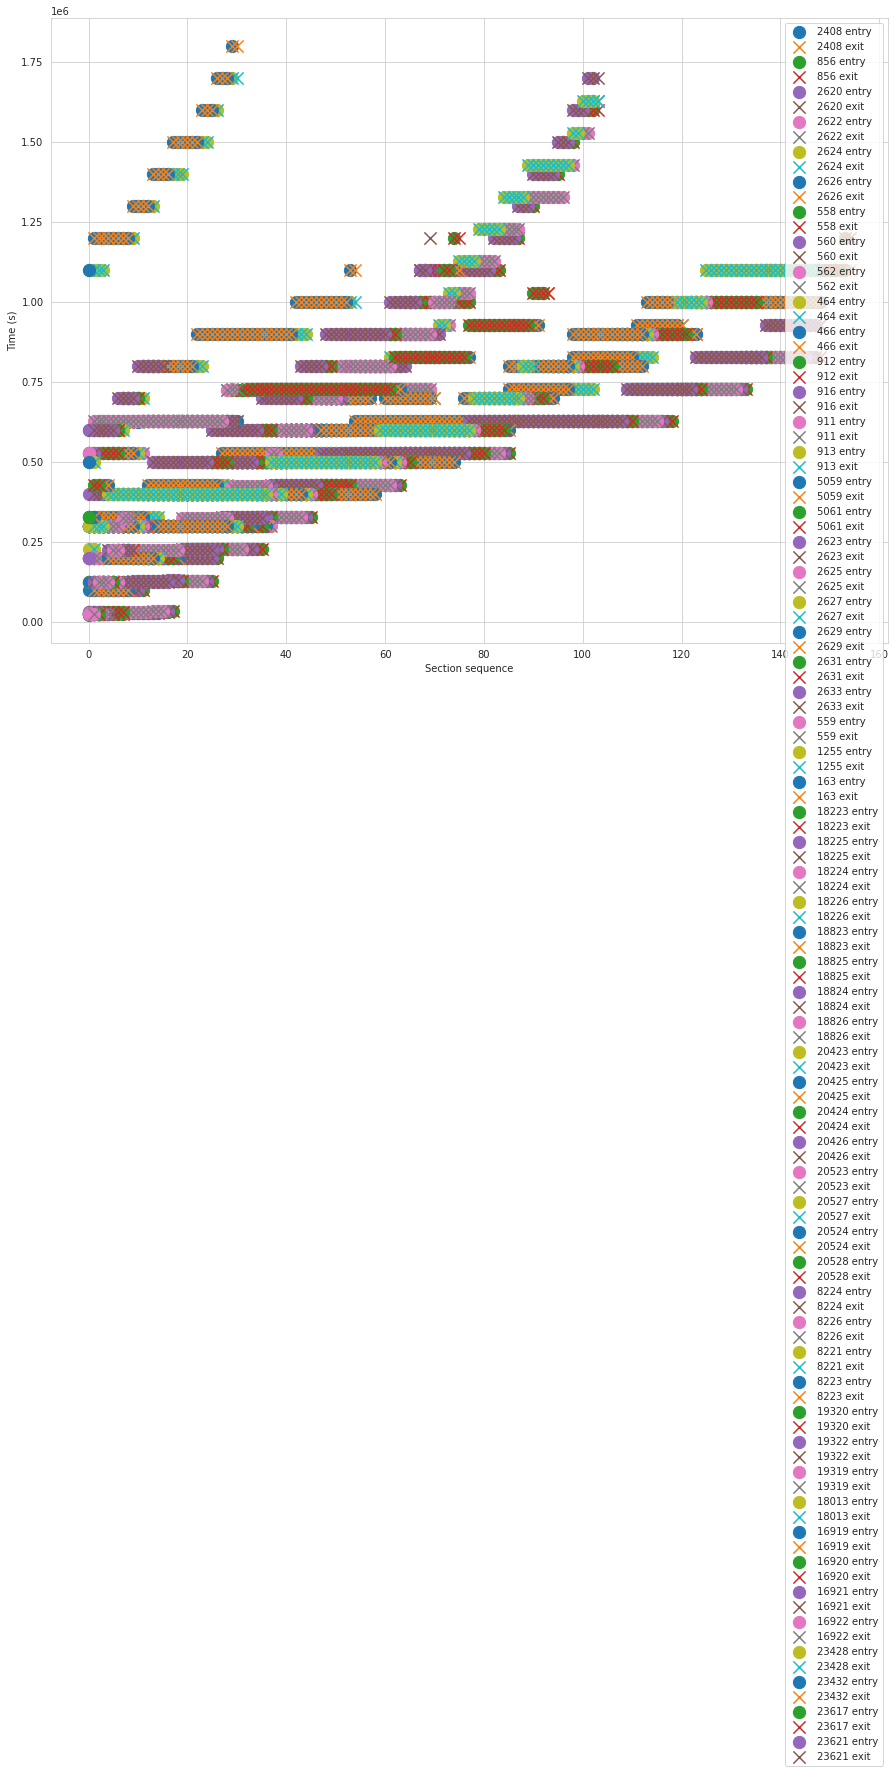

In [64]:
display_solution(x.value, 1, 150)

In [ ]:
non_binary = []
for i in range(total_length):
    if i not in bool_idx:
        non_binary.append(i)

In [1]:
#def solve_mosek(At, b, bool_idx):
from mosek.fusion import *
import sys

with Model() as M:
    

    x = M.variable('x',  total_length  , Domain.greaterThan(0.0))#Domain.binary())

    for idx in bool_idx:
        x.index(idx).makeInteger()
        M.constraint(x.index(idx), Domain.lessThan(1.5))
    M.constraint('c1', Expr.mul(At, x), Domain.lessThan(bt))
    print(x.getShape())
    # Set the objective function to (c^T * x)
    M.objective('obj', ObjectiveSense.Minimize, Expr.dot(c, x))

    # Assign values to integer variables.
    # We only set a slice of xx
    #init_sol = [1.0, 1.0, 0.0]
    #x.slice(0,3).setLevel(init_sol)

    # Solve the problem
    M.setLogHandler(sys.stdout)
    M.solve()

    # Get the solution values
    ss = M.getPrimalSolutionStatus()
    print("Solution status: {0}".format(ss))
    sol = x.level()
    print('x = {0}'.format(sol))

    # Was the initial solution used?
    constr = M.getSolverIntInfo("mioConstructSolution")
    constrVal = M.getSolverDoubleInfo("mioConstructSolutionObj")
    print("Initial solution utilization: {0}\nInitial solution objective: {1:.3f}\n".format(constr, constrVal))    

NameError: name 'total_length' is not defined

In [ ]:
sol

In [ ]:
j=0
con=9
for i in bool_idx:
    if j == con:
        j=0
        print('----')
        if con==9:
            con=14
        else:
            con=9
    j+=1
    print(sol[i], x.value[i])

In [ ]:
x_star = x.value
g = A_coup@x_star-b_coup
np.linalg.norm(g,2)

In [ ]:
lam = np.zeros(len(b_coup))
errors = []
xvals = []
for i in range(100):

    bool_vars_idx = [(x,) for x in bool_idx]

    x = cp.Variable(A.shape[1], boolean = bool_vars_idx)

    p = cp.Problem(cp.Minimize(c.T@x - lam.T@(A_coup@x - b_coup) ),
                     [A@x<=b])
    p = p.solve(solver = 'MOSEK', verbose = False)

    
    x = x.value
    xvals.append(x)
    
    g = A_coup@x-b_coup
    errors.append(np.linalg.norm(g,2))

    bool_vars_idx = [(x,) for x in bool_idx]

    lam = cp.Variable(len(b_coup))

    p = cp.Problem(cp.Maximize(lam.T@(A_coup@x - b_coup) ),
                     [lam >=0, c.T + lam.T@A_coup >=0])
    p = p.solve(solver = 'MOSEK', verbose = False)
    
    lam = lam.value



In [ ]:
vecerrors = np.array([np.linalg.norm(v-x_star,2) for v in xvals])
vecerrors/=max(vecerrors)
errors = np.array(errors)
errors /= max(errors)

In [ ]:
err

In [ ]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.plot(vecerrors)

In [ ]:
x = cp.Variable(A_coup.shape[1], boolean = bool_vars_idx)
p = cp.Problem(cp.Minimize(c.T@x) ,
                 [A_coup@x<=b_coup])
p = p.solve(solver = 'MOSEK', verbose = True)

In [ ]:
lam = np.zeros(len(b_coup))
A=np.vstack((A,A_coup))
b = np.hstack((b, b_coup))
bool_vars_idx = [(x,) for x in bool_idx]

x = cp.Variable(A.shape[1], boolean = bool_vars_idx)

p = cp.Problem(cp.Minimize(c.T@x),
                 [A@x<=b])
p.solve(solver = 'MOSEK', verbose = True)

lam = cp.Variable(len(b))

d = cp.Problem(cp.Maximize(-b.T@lam),
                 [A.T@lam + c ==0, lam >=0 ])
d.solve(solver = 'MOSEK', verbose = True)

In [ ]:
bool_vars_idx = [(x,) for x in bool_idx]

lam = np.ones(len(b_coup))
max_iter = 10000
tolerance = 0.5
x = cp.Variable(A.shape[1], boolean = bool_vars_idx)

lb = -np.inf
ub = np.inf
currbest = ub
error = []
j= 0 
divider=2
z=100
for i in range(max_iter):
    print('iteration',i)
    #print('solving decoupled', i)
    #x = cp.Variable(A.shape[1], boolean = bool_vars_idx)
    #p_sub = cp.Problem(cp.Minimize(c.T@x),
    #             [A@x<=b])
    #print(lam)
    #z = p_sub.solve(solver = 'MOSEK', verbose = True)    
    #x = x.value

    #print('solving dual', i)
    #d = cp.Problem(cp.Maximize( -np.hstack((b,b_coup)).T@lam ),
    #         [np.vstack((A,A_coup)).T@lam +c == 0, lam>=0])
    
    #d_star = d.solve(solver = 'MOSEK', verbose = True) 
    #print('solving relaxed', i)
    #lam = cp.Variable(len(b_coup))
    x = cp.Variable(A.shape[1], boolean = bool_vars_idx)
    r = cp.Problem(cp.Minimize(c.T@x +  lam.T@(A_coup@x -b_coup) ),
                 [A@x<=b])
    try:
        z = r.solve(solver = 'MOSEK', verbose = False)
        print(z)
        x = x.value
        xprev = x.copy()
    except:
        lam = lamprev.copy()
        divider = divider/2
        x=xprev.copy()
        print('failed')

    g = A_coup@x-b_coup
    error.append(np.linalg.norm(g,2))
    
    if z<currbest:
        currbest = z
    else:
        if j==10:
            divider = divider/2
            j=0
        
    
    step = divider*z/np.linalg.norm(g,2)
    if np.linalg.norm(g,2)<=tolerance:
        break
    else:
        lamprev = lam.copy()
        lam = np.maximum(0,lam+g*step)
        #lam = np.round(lam)
    j+=1

In [ ]:
r.objective.value

In [ ]:
plt.plot(error)

### Solver

### Lagrangian relaxation

In [ ]:
A = A.astype(float)
A[A.nonzero()]=1
from matplotlib import pyplot as plt
(x,y) = A.shape
S=5
plt.figure(figsize = (S,int(S*x/y)))
plt.imshow(A, cmap='Greys',  interpolation='nearest')

### Constraint check